In [52]:
using Revise

using EzXML
using Plots
using CSV
using DataFrames
using StatsBase
using Graphs, MetaGraphs, GraphPlot
using LRUCache
using Serialization
using Colors

using Statistics

includet("src/lfu_cache.jl")
using Main.LFUCache

includet("src/simulation.jl")
using Main.Simulation

includet("src/helper.jl")
using Main.Helper

In [53]:
log_df = Dict()

Dict{Any, Any}()

In [54]:
steps_per_hour = 6

network = load_graph("data/weights.intra")
n_links_used = links_used(network);
traffic = get_traffic_stats(10);

# optimization
opt_placement_array = deserialize("temp/y_200.dat")
opt_oracle = deserialize("temp/x_200.dat") |> x -> permutedims(x,(1,3,2))

opt_placement_array2 = deserialize("temp/y_lag.dat")
opt_oracle2 = deserialize("temp/x_lag.dat") |> x -> permutedims(x,(1,3,2))

# videos
df = load_videos("data/videos.txt", 200);
#df[!,:prob] .= 1/200;

,url,length,views,ratings,stars,prob
,String31,String15,Int64,Int64,Float64,Float64
1,/watch?v=lsO6D1rwrKc,02:44,8567247,9135,4.5,0.0339009
2,/watch?v=vr3x_RRJdd4,03:39,8056321,29272,4.5,0.0318791
3,/watch?v=ixsZy2425eY,02:42,6762465,6171,4.5,0.0267593
4,/watch?v=RUCZJVJ_M8o,00:11,6596499,12201,4.5,0.0261026
5,/watch?v=tFXLbXyXy6M,03:19,5371920,2232,4.5,0.0212569
6,/watch?v=jtExxsiLgPM,04:29,5190212,1208,3.5,0.0205378
7,/watch?v=SmLhyPjHVes,00:57,5138585,1467,3.5,0.0203335
8,/watch?v=2KrdBUFeFtY,01:45,4112953,11142,4.5,0.0162751
9,/watch?v=5bry10DU8bo,04:30,3793255,2527,3.5,0.01501


In [55]:
# steps per day (traces per day)
function generate_trace(t, videos_df, traffic; daily_queries=100000, steps_per_day=24)
    daily_queries = daily_queries*7 # traffic is weekly
    traffic_currently = traffic[mod(t, steps_per_day*7)+1]
    queries = ((daily_queries/24) *steps_per_day* traffic_currently) |> floor |> Int
    
    sample(videos_df[!, :url], ProbabilityWeights(videos_df[!, :prob]), queries)
end

generate_trace (generic function with 1 method)

In [56]:
mutable struct DatacenterNode
    name::String
    connections::Int
    misses::Int
    videos
    cache
end

# functions

function init_nodes_from_opt(mg, videos, placement)
    dict = Dict()

    for vertex in vertices(mg)
        name = get_prop(mg, vertex, :name)
        #videos = first(df, 10)[!, :url]
        videos = placement[vertex]
        dict[vertex] = DatacenterNode(name, 0,0,videos,LRU(maxsize=10))
    end

    dict
end


function init_nodes(mg, videos, type)
    dict = Dict()

    for vertex in vertices(mg)
        name = get_prop(mg, vertex, :name)
        videos = if type != :TOPLRU sample(df[!, :url], 20) else vcat(first(df, 10)[!, :url], sample(df[!, :url], 10)) end

        cache = if (type == :LRU || type == :TOPLRU) LRU(maxsize=10) else LFU(maxsize=10) end
        dict[vertex] = DatacenterNode(name, 0,0,Set(videos), cache)
    end

    dict
end

function handle_connection(node, filename)
    if !(filename in node.videos)
        if !(filename in keys(node.cache))
            node.misses += 1
            node.cache[filename] = true
        end
    end

    node.connections += 1
    node
end

function advance_timeframe(node)
    time_int = 60/steps_per_hour
    video_size = 1
    bandwidth = ((node.misses * video_size)/(60*time_int))*8

    stats = Dict(:bandwidth => bandwidth, :misses => node.misses, :connections => node.connections)

    node.connections = 0
    node.misses = 0

    return stats
end

function simulate(network, df, video_oracle, n_links_used, edges, bandwidth=15.0)
    # use just the first node^
    node_logs = Dict()
    steps_per_day = 60
    edge_bandwidths =  zeros(Float32, steps_per_day*7, edges)

    video_key_to_id = Dict((x,i) for (i,x) in enumerate(df[!, :url]))

    for (idx,node) in network
        log = []
        for t in 1:(steps_per_day)*7
            videos = generate_trace(t*Int(240/steps_per_day), df, traffic; steps_per_day=240 ,daily_queries=10000)

            for video in videos
                handle_connection(node, video)

                video_id = video_key_to_id[video]

                if video_oracle[video_id,idx,idx] >= 0.99
                    continue
                end
                
                node_prob = video_oracle[video_id, idx, :]
                selected_node = sample(1:length(network), ProbabilityWeights(node_prob))
                links = n_links_used[idx, selected_node]
                for link in links
                    edge_bandwidths[t,link] += bandwidth
                end

                
            end

            append!(log, [advance_timeframe(node)])
        end
        node_logs[idx] = DataFrame([NamedTuple{Tuple(keys(d))}(values(d)) for d in log])
    end

    (node_logs, edge_bandwidths)
end

simulate (generic function with 2 methods)

In [57]:
settings = [
    Dict(:name => "MIP + LRU", :network => init_nodes_from_opt(network, df, get_videos_from_array(network, opt_placement_array, df)), :generate_oracle => false),
    Dict(:name => "Relaxed MIP + LRU", :network => init_nodes_from_opt(network, df, get_videos_from_array(network, opt_placement_array2, df)), :generate_oracle => false),
    #Dict(:name => "Top + LRU", :network => init_nodes(network, df, :TOPLRU), :generate_oracle => true),
    #Dict(:name => "Random + LRU", :network => init_nodes(network, df, :LRU), :generate_oracle => true),
    #Dict(:name => "Random + LFU", :network => init_nodes(network, df, :LFU), :generate_oracle => true),
]

Threads.@threads for setting in settings
    println("Simulating $(setting[:name])")
    name = setting[:name]

    dc_network = setting[:network]
    video_oracle = if setting[:generate_oracle] generate_oracle(dc_network, network, df) else opt_oracle end
    if name == "Relaxed MIP + LRU"
        video_oracle = opt_oracle2
    end
    log_df[name] = simulate(dc_network, df, video_oracle, n_links_used, length(edges(network)))
end

Simulating MIP + LRU
Simulating Relaxed MIP + LRU


In [58]:
data = []

for (key, val) in log_df
    v_df = val[1] |> values
    v_data = val[2]

    bandwidth_usage = mean([mean(v_data[i,:]) for i in 1:size(v_data)[1]])

    #bandwidth = v_df|> y -> map(x -> x[!,:bandwidth], y) |> x -> hcat(x...) |> x -> rowwise(mean,x) |> mean
    misses = v_df|> y -> map(x -> x[!,:misses], y) |> x -> hcat(x...) |> x -> rowwise(sum,x) |> sum
    connections = v_df|> y -> map(x -> x[!,:connections], y) |> x -> hcat(x...) |> x -> rowwise(sum,x) |> sum
    cache_hits = (connections - misses) / connections
    cache_misses = ( misses) / connections


    push!(data, (key=key , misses=misses, connections=connections, cache_hits=cache_hits, cache_misses=cache_misses, avg_bandwidth_usage=bandwidth_usage))
end


println("Vertices: $(length(vertices(network))) Edges: $(length(edges(network)))")

DataFrame(data)

Vertices: 79 Edges: 294


,key,misses,connections,cache_hits,cache_misses,avg_bandwidth_usage
,String,Int64,Int64,Float64,Float64,Float32
1,Relaxed MIP + LRU,9405305,13823104,0.319595,0.680405,1764.13
2,MIP + LRU,10252246,13823104,0.258325,0.741675,2156.63


In [59]:
# calculate the median of each row of log_df[2]
Plots.plot(
    [ [mean(v[2][i,:]) for i in 1:size(v[2])[1]] for (k,v) in log_df ],
    ribbons=hcat([ [std(v[2][i,:]) |> sqrt for i in 1:size(v[2])[1]] for (k,v) in log_df ]...),
    labels=hcat([k for (k,v) in log_df]...),
    ylims = (0, 5500),
    #yticks = 0:500:6000,
    xticks = (60:420/7:420, ["Day $i" for i in 1:7]),
    ylabel="Mean link bandwidth (Mbps)",
)
savefig("plots/mean_band.pdf")

In [60]:
# calculate the median of each row of log_df[2]
Plots.plot(
    [ [sum(v[2][i,:]) for i in 1:size(v[2])[1]] for (k,v) in log_df ]/1000,
    labels=hcat([k for (k,v) in log_df]...),
    #ylims = (0, 2000),
    #yticks = 0:200:3500,
    xticks = (60:420/7:420, ["Day $i" for i in 1:7]),
    ylabel="Agg. link bandwidth (Gbps)",
)
savefig("plots/agg_band.pdf")

In [61]:
Plots.plot(
    [ [maximum(v[2][i,:]) for i in 1:size(v[2])[1]] for (k,v) in log_df ]/1000,
    labels=hcat([k for (k,v) in log_df]...),
    ylims = (0, 20),
    #yticks = 0:2:40,
    xticks = (60:420/7:420, ["Day $i" for i in 1:7]),
    ylabel="Max. link bandwidth (Gbps)",
)
savefig("plots/max_band.pdf")

In [62]:
#header = ["name", "misses", "connections", "locally served queries (%)", "average link bandwidth usage (Mbps)"]
data = []

for (key, val) in log_df
    v_df = val[1] |> values
    v_data = val[2]

    bandwidth_usage = mean([mean(v_data[i,:]) for i in 1:size(v_data)[1]])

    #bandwidth = v_df|> y -> map(x -> x[!,:bandwidth], y) |> x -> hcat(x...) |> x -> rowwise(mean,x) |> mean
    misses = v_df|> y -> map(x -> x[!,:misses], y) |> x -> hcat(x...) |> x -> rowwise(sum,x) |> sum
    connections = v_df|> y -> map(x -> x[!,:connections], y) |> x -> hcat(x...) |> x -> rowwise(sum,x) |> sum
    locally_served = (connections - misses) / connections
    max_bandwidth = maximum(v_data)

    push!(data, (key=key , misses=misses, connections=connections, locally_served=locally_served, avg_bandwidth_usage=bandwidth_usage, max_bandwidth=max_bandwidth))
end


println("Vertices: $(length(vertices(network))) Edges: $(length(edges(network)))")

using CSV
CSV.write("plots/stats.csv",DataFrame(data))

DataFrame(data)

Vertices: 79 Edges: 294


,key,misses,connections,locally_served,avg_bandwidth_usage,max_bandwidth
,String,Int64,Int64,Float64,Float32,Float32
1,Relaxed MIP + LRU,9405305,13823104,0.319595,1764.13,13080.0
2,MIP + LRU,10252246,13823104,0.258325,2156.63,9120.0


In [64]:
# video popularity distribution
Plots.plot(df[!,:prob], 
    xlabel="Videos (in decreasing order of popularity)", 
    ylabel="Relative Views (in %)", 
    legend=false)
savefig("plots/distribution.pdf")

In [206]:
colormap("RdBu")

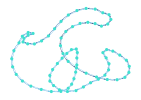

In [178]:
bandwidth = log_df["MIP + LRU"][2][100,:]
layout=(arg)->spring_layout(arg, 10)
gplot(network,
    layout=layout,
    arrowlengthfrac=0.03,
    #edgelinewidth=bandwidth,
    edgestrokec=colormap("Blues",1001)[1 .+ trunc.(Int,bandwidth/maximum(bandwidth)*1000)],
    linetype="curve",
    outangle=π/20
)

In [177]:
bandwidth = log_df["Radnom + LRU"][2][100,:]
layout=(arg)->spring_layout(arg, 10)
gplot(network,
    layout=layout,
    arrowlengthfrac=0.03,
    #edgelinewidth=bandwidth,
    edgestrokec=colormap("Blues",1001)[1 .+ trunc.(Int,bandwidth/maximum(bandwidth)*1000)],
    linetype="curve",
    outangle=π/20
)

KeyError: KeyError: key "Radnom + LRU" not found

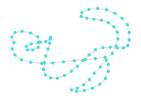

In [122]:
layout=(arg)->spring_layout(arg, 10)
gplot(network,
    #layout=layout,
    arrowlengthfrac=0.03,
    #edgelinewidth=bandwidth,
    linetype="curve",
    outangle=π/20
)

In [44]:
graphplot(network,edge_width=(bandwidth/maximum(bandwidth))*5,tfactor=0.1)

UndefVarError: UndefVarError: graphplot not defined

In [45]:
using Serialization
serialize("temp/results.dat", log_df)

In [154]:
opt_oracle

200×79×79 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱                 ⋮              
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  